# Normalizing flows in PyTorch

One of the key in modern generative models is to find ways of optimizing the probability distribution of a given set of data. The recent idea of *Normalizing Flows* [[1](#reference1),[2](#reference)] addresses this problem and be able to rely on richer probability distributions. The main idea is to start from a simple probability distribution and approximate a complex multimodal density by *transforming* the simpler density through a sequence of invertible nonlinear transforms. To fully understand this blazing tool, we will see in this tutorial

1. The new [PyTorch distributions](#distribs) module and how to use it
2. How transforming a distribution is expressed as a [change of variables](#change) leading to a flow
3. How we can [chain multiple transforms](#chaining) leading to the overall framework of normalizing flows
4. Understanding the original [planar flow](#planar), its parameters and how to implement it
5. Defining [learnable flows](#learning) and performing optimization on a target density


<a id="distribs"></a>
### PyTorch distributions

In this tutorial, we are going to rely on the novel [PyTorch distributions module](https://pytorch.org/docs/stable/_modules/torch/distributions/), which is defined in `torch.distributions`. Most notably, we are going to rely both on the `Distribution` and `Transform` objects.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform
# Imports for plotting
import numpy as np
import matplotlib.pyplot as plt
from helper_plot import hdr_plot_style
hdr_plot_style()
# Define grids of points (for later plots)
x = np.linspace(-4, 4, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

Inside this toolbox, we can already find some of the major probability distributions that we are used to deal with


In [2]:
p = distrib.Normal(loc=0, scale=1)
p = distrib.Bernoulli(probs=torch.tensor([0.5]))
p = distrib.Beta(concentration1=torch.tensor([0.5]), concentration0=torch.tensor([0.5]))
p = distrib.Gamma(concentration=torch.tensor([1.0]), rate=torch.tensor([1.0]))
p = distrib.Pareto(alpha=torch.tensor([1.0]), scale=torch.tensor([1.0]))

The interesting aspect of these `Distribution` objects is that we can both obtain some samples from it through the `sample` (or `sample_n`) function, but we can also obtain the analytical density at any given point through the `log_prob` function

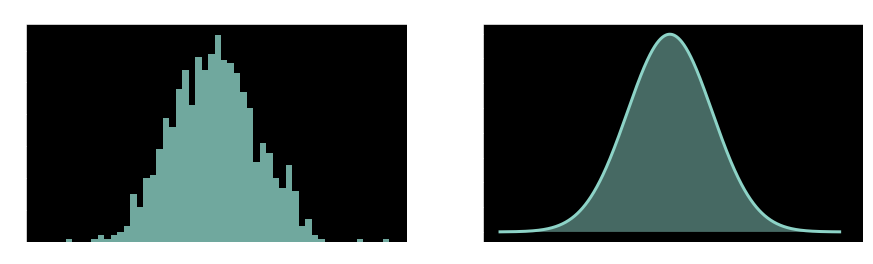

In [3]:
# Based on a normal
n = distrib.Normal(0, 1)
# Obtain some samples
samples = n.sample((1000, ))
# Evaluate true density at given points
density = torch.exp(n.log_prob(torch.Tensor(x))).numpy()
# Plot both samples and density
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 4))
ax1.hist(samples, 50, alpha=0.8);
ax1.set_title('Empirical samples', fontsize=18);
ax2.plot(x, density); ax2.fill_between(x, density, 0, alpha=0.5)
ax2.set_title('True density', fontsize=18);

<a id="change"></a>
## Transforming distributions

### Change of variables and flow

In order to transform a probability distribution, we can perform a *change of variable*. As we are interested in probability distributions, we need to *scale* our transformed density so that the total probability still sums to one. This is directly measured with the determinant of our transform.

Let $\mathbf{z}\in\mathcal{R}^d$ be a random variable with distribution $q(\mathbf{z})$ and $f:\mathcal{R}^d\rightarrow\mathcal{R}^d$ an invertible smooth mapping (meaning that $f^{-1} = g$ and $g\circ f(\mathbf{z})=\mathbf{z}'$. We can use $f$ to transform $\mathbf{z}\sim q(\mathbf{z})$. The resulting random variable $\mathbf{z}'=f(\mathbf{z})$ has the following probability distribution

$$
q(\mathbf{z}')=q(\mathbf{z})\left|\text{ det}\frac{\delta f^{-1}}{\delta \mathbf{z}'}\right| = q(\mathbf{z})\left|\text{ det}\frac{\delta f}{\delta \mathbf{z}}\right|^{-1}
\tag{1}
$$

where the last equality is obtained through both the inverse function theorem [1] and the property of Jacobians of invertible functions. Therefore, we can transform probability distributions with this property.

Fortunately, this can be easily implemented in PyTorch with the `Transform` classes, that already defines some basic probability distribution transforms. For instance, if we define $\mathbf{z}\sim q_0(\mathbf{z})=\mathcal{N}(0, 1)$, we can apply the transform $\mathbf{z}'=exp(\mathbf{z})$ so that $\mathbf{z}'\sim q_1(\mathbf{z}')$

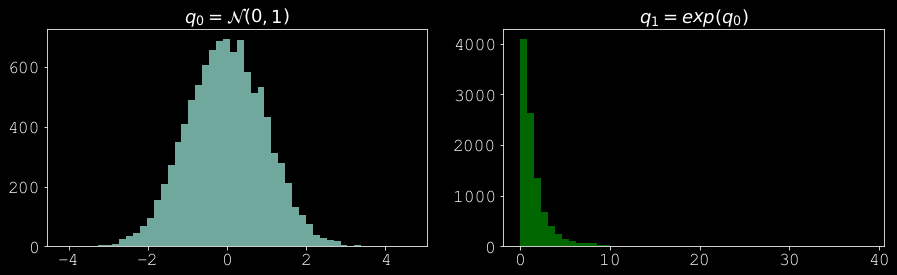

In [6]:
q0 = distrib.Normal(0, 1)
exp_t = transform.ExpTransform()
q1 = distrib.TransformedDistribution(q0, exp_t)
samples_q0 = q0.sample((int(1e4),))
samples_q1 = q1.sample((int(1e4),))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.hist(samples_q0, 50, alpha=0.8);
ax1.set_title('$q_0 = \mathcal{N}(0,1)$', fontsize=18);
ax2.hist(samples_q1, 50, alpha=0.8, color='g');
ax2.set_title('$q_1=exp(q_0)$', fontsize=18);

But remember as the objects `q0` and `q1` are defined as `Distribution`, we can actually observe their true densities instead of just empirical samples

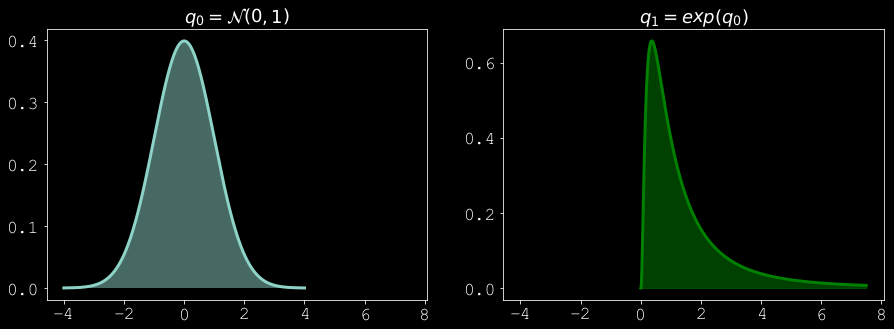

In [7]:
hdr_plot_style()
x2 = np.linspace(-0.5, 7.5, 1000)
q0_density = torch.exp(q0.log_prob(torch.Tensor(x))).numpy()
q1_density = torch.exp(q1.log_prob(torch.Tensor(x2))).numpy()
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 5))
ax1.plot(x, q0_density); ax1.fill_between(x, q0_density, 0, alpha=0.5)
ax1.set_title('$q_0 = \mathcal{N}(0,1)$', fontsize=18);
ax2.plot(x2, q1_density, color='g'); ax2.fill_between(x2, q1_density, 0, alpha=0.5, color='g')
ax2.set_title('$q_1=exp(q_0)$', fontsize=18);
fig.savefig('transform.pdf')

What we obtain here with `q1` is actually the `LogNormal` distribution. Interestingly, several distributions in the `torch.distributions` module are already defined based on `TransformedDistribution`. You can convince yourself of that by lurking in the code of the [`torch.distributions.LogNormal`](https://pytorch.org/docs/stable/_modules/torch/distributions/log_normal.html#LogNormal)

<a id="chaining"></a>
### Chaining transforms (normalizing flows)

Now, if we start with a random vector $\mathbf{z}_0$ with distribution $q_0$, we can apply a series of mappings $f_i$, $i \in 1,\cdots,k$ with $k\in\mathcal{N}^{+}$ and obtain a normalizing flow. Hence, if we apply $k$ normalizing flows, we obtain a chain of change of variables

$$
\mathbf{z}_k=f_k\circ f_{k-1}\circ...\circ f_1(\mathbf{z}_0)
\tag{2}
$$

Therefore the distribution of $\mathbf{z}_k\sim q_k(\mathbf{z}_k)$ will be given by
   
   $$
   \begin{align}
   q_k(\mathbf{z}_k) &= q_0(f_1^{-1} \circ f_{2}^{-1} \circ ... \circ f_k^{-1}(\mathbf{z}_k))\prod_{i=1}^k\left|\text{det}\frac{\delta f^{-1}_i}{\delta\mathbf{z}_{i}}\right|\\
   &= q_0(\mathbf{z_0})\prod_{i=1}^k\left|\text{det}\frac{\delta f_i}{\delta\mathbf{z}_{i-1}}\right|^{-1}
   \end{align}
   \tag{3}
   $$
    
where we compute the determinant of the Jacobian of each normalizing flow (as explained in the previous section). This series of transformations can transform a simple probability distribution (e.g. Gaussian) into a complicated multi-modal one. As usual, we will rely on log-probabilities to simplify the computation and obtain 

$$
\text{log} q_K(\mathbf{z}_k) = \text{log} q_0(\mathbf{z}_0) - \sum_{i=1}^{k} \text{log} \left|\text{det}\frac{\delta f_i}{\delta\mathbf{z}_{i-1}}\right| 
\tag{4}
$$


To be of practical use, however, we can consider only transformations whose determinants of Jacobians are easy to compute. Of course, we can perform any amount of combined transformations, and it also works with multivariate distributions. Here, this is demonstrated by transforming a `MultivariateNormal` successively with an `ExpTransform` and `AffineTransform`. (Note that the final distribution `q2` is defined as a `TransformedDistribution` directly with a *sequence* of transformations)

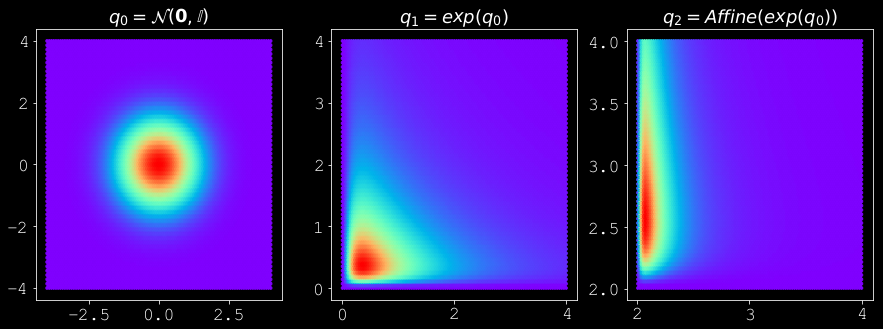

In [8]:
q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
# Define an affine transform
f1 = transform.ExpTransform()
q1 = distrib.TransformedDistribution(q0, f1)
# Define an additional transform
f2 = transform.AffineTransform(2, torch.Tensor([0.2, 1.5]))
f1(x) => f1._call(x)
=> f1.log_abs_det_jacobian()
# Here I define on purpose q2 as a sequence of transforms on q0
q2 = distrib.TransformedDistribution(q0, [f1, f2])
# Plot all these lads
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=torch.exp(q0.log_prob(torch.Tensor(z))), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(z[:,0], z[:,1], C=torch.exp(q1.log_prob(torch.Tensor(z))), cmap='rainbow')
ax2.set_title('$q_1=exp(q_0)$', fontsize=18);
ax3.hexbin(z[:,0], z[:,1], C=torch.exp(q2.log_prob(torch.Tensor(z))), cmap='rainbow')
ax3.set_title('$q_2=Affine(exp(q_0))$', fontsize=18);

<a id="planar"></a>
## Normalizing flows

Now, we are interested in normalizing flows as we could define our own flows. And, most importantly, we could optimize the parameters of these flow in order to fit complex and richer probability distributions. We will see how this plays out by trying to implement the *planar flow* proposed in the original paper by Rezende [1].

### Planar flow

 A planar normalizing flow is defined as a function of the form

   $$
   f(\mathbf{z})=\mathbf{z}+\mathbf{u}h(\mathbf{w}^T\mathbf{z}+b)
   \tag{5}
   $$

   where $\mathbf{u}\in\mathbb{R}^D$ and $\mathbf{w}\in\mathbb{R}^D$ are vectors (called here scale and weight), $b\in\mathbb{R}$ is a scalar (bias) and $h$ is an activation function. These transform functions are chosen depending on the fact that
1. the determinant of their Jacobian can be computed in linear time
2. the transformation is invertible (under usually mild conditions only)
   
As shown in the paper, for the planar flow, the determinant of the Jacobian can be computed in $O(D)$ time by relying on the matrix determinant lemma

$$
\psi(\mathbf{z})=h'(\mathbf{w}^T\mathbf{z}+b)\mathbf{w}
\tag{6}
$$

$$
\left|\text{det}\frac{\delta f}{\delta\mathbf{z}}\right| = \left|\text{det}\left(\mathbf{I}+\mathbf{u}\psi(\mathbf{z})^{T}\right)\right|=\left|1+\mathbf{u}^T\psi(\mathbf{z})\right|
\tag{7}
$$

Therefore, we have all definitions that we need to implement this flow as a `Transform` object. Note that here the non-linear activation function $h$ is selected as a $tanh$. Therefore the derivative $h'$ is $1-tanh(x)^2$

In [10]:
class PlanarFlow(transform.Transform):

    def __init__(self, weight, scale, bias):
        super(PlanarFlow, self).__init__()
        self.bijective = False
        self.weight = weight
        self.scale = scale
        self.bias = bias

    def _call(self, z):
        
        ######################
        # YOUR CODE GOES HERE
        ######################
    
        ######################
        # Solution
        f_z = F.linear(z, self.weight, self.bias)
        f_z = z + self.scale * torch.tanh(f_z)
        ######################
        
        return f_z

    def log_abs_det_jacobian(self, z):
        
        ######################
        # YOUR CODE GOES HERE
        ######################
    
        ######################
        # Solution
        f_z = F.linear(z, self.weight, self.bias)
        psi = (1 - torch.tanh(f_z) ** 2) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        abs_log_det = torch.log(det_grad.abs() + 1e-7)
        ######################
        
        return abs_log_det

As before, we can witness the effect of this transform on a given `MultivariateNormal` distribution. You should note here that I am using the density estimation for `q0`, but only display empirical samples from `q1`.

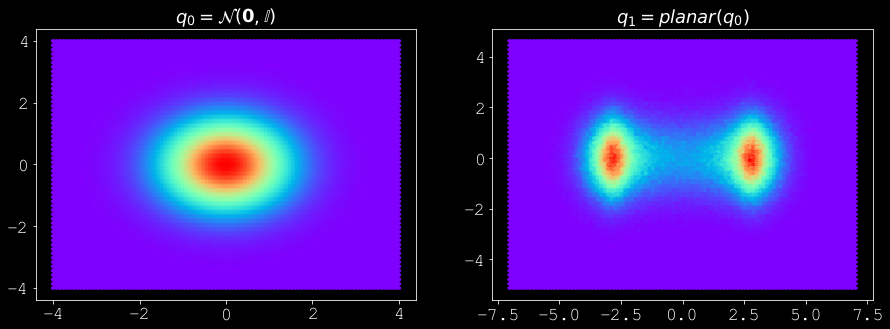

In [11]:
w = torch.Tensor([[3., 0]])
u = torch.Tensor([[2, 0]])
b = torch.Tensor([0])
q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
flow_0 = PlanarFlow(w, u, b)
q1 = distrib.TransformedDistribution(q0, flow_0)
q1_samples = q1.sample((int(1e6), ))
# Plot this
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=torch.exp(q0.log_prob(torch.Tensor(z))), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(q1_samples[:,0], q1_samples[:,1], cmap='rainbow')
ax2.set_title('$q_1=planar(q_0)$', fontsize=18);

The reason for this is that the `PlanarFlow` is not invertible in all regions of the space. However, if we recall the mathematical reasoning of the previous section, we can see how the change of variables plays out if we are able to compute the determinant of the Jacobian of this transform.

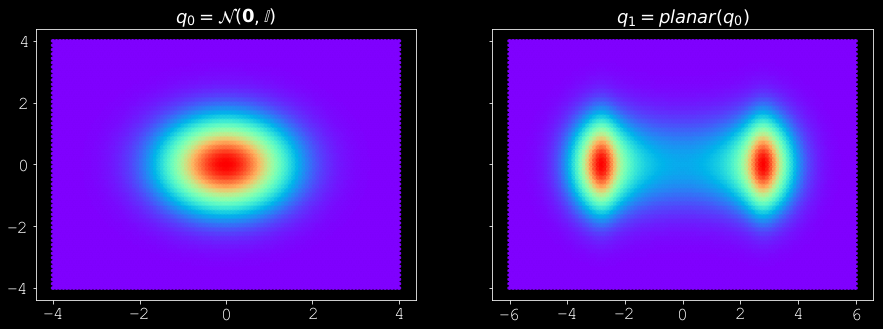

In [12]:
q0_density = torch.exp(q0.log_prob(torch.Tensor(z)))
# Apply our transform on coordinates
f_z = flow_0(torch.Tensor(z))
# Obtain our density
q1_density = q0_density.squeeze() / np.exp(flow_0.log_abs_det_jacobian(torch.Tensor(z)).squeeze())
# Plot this
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=q0_density.numpy().squeeze(), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(f_z[:,0], f_z[:,1], C=q1_density.numpy().squeeze(), cmap='rainbow')
ax2.set_title('$q_1=planar(q_0)$', fontsize=18);

So we were able to "split" our distribution and transform a unimodal gaussian into a multimodal distribution ! Pretty neat 

### Visualizing parameters effects

Here, we provide a little toy example so that you can play around with the parameters of the flow in order to get a better understanding of how it operates. As put forward by Rezende [1], this flow is related to the hyperplane defined by $\mathbf{w}^{T}\mathbf{z}+b=0$ and transforms the original density by applying a series of contractions and expansions in the direction perpendicular to this hyperplane.


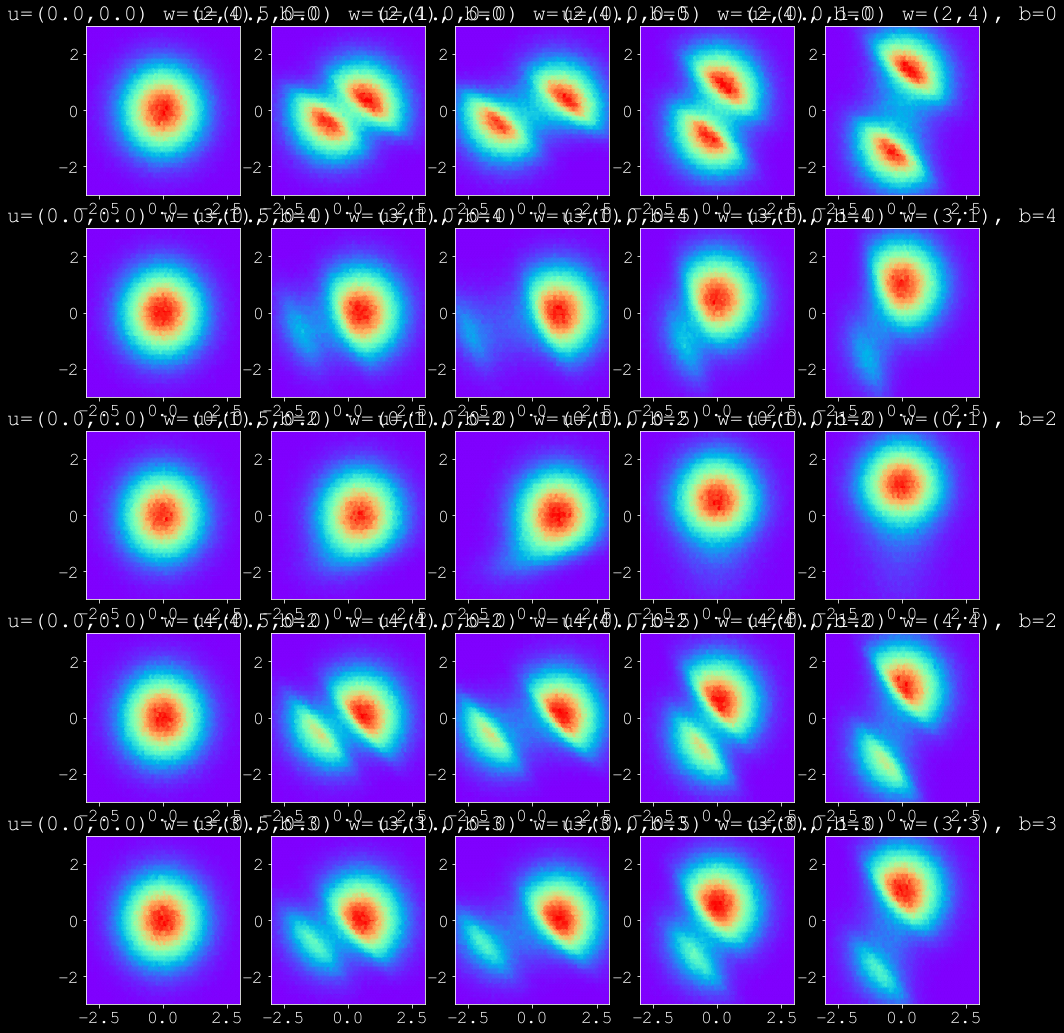

In [13]:
id_figure=1
plt.figure(figsize=(16, 18))
for i in np.arange(5):
    # Draw a random hyperplane
    w = torch.rand(1, 2) * 5
    b = torch.rand(1) * 5
    for j in np.arange(5):
        # Different effects of scaling factor u on the same hyperplane (row)
        u = torch.Tensor([[((j < 3) and (j / 2.0) or 0), ((j > 2) and ((j - 2) / 2.0) or 0)]])
        flow_0 = PlanarFlow(w, u, b)
        q1 = distrib.TransformedDistribution(q0, flow_0)
        q1_samples = q1.sample((int(1e6), ))
        plt.subplot(5,5,id_figure)
        plt.hexbin(q1_samples[:,0], q1_samples[:,1], cmap='rainbow')
        plt.title("u=(%.1f,%.1f)"%(u[0,0],u[0,1]) + " w=(%d,%d)"%(w[0,0],w[0,1]) + ", " + "b=%d"%b)
        plt.xlim([-3, 3])
        plt.ylim([-3, 3])
        id_figure += 1

<a id="learning"></a>
## Optimizing normalizing flows

Now that we have this magnificent tool, we would like to apply this in order to learn richer distributions and perform *inference*. Now, we have to deal with the fact that the `Transform` object is not inherently parametric and cannot yet be optimized similarly to other modules.

To do so, we will start by defining our own `Flow` class which can be seen both as a `Transform` and also a `Module`that can be optmized

In [14]:
class Flow(transform.Transform, nn.Module):
    
    def __init__(self):
        transform.Transform.__init__(self)
        nn.Module.__init__(self)
    
    # Init all parameters
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)
            
    # Hacky hash bypass
    def __hash__(self):
        return nn.Module.__hash__(self)

Thanks to this little trick, we can use the same `PlanarFlow` class as before, that we put back here just to show that the only change is that it now inherits from the `Flow` class (with the small added bonus that now parameters of this flow are also registered in the `Module` interface)

In [12]:
class PlanarFlow(Flow):

    def __init__(self, dim):
        super(PlanarFlow, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(1, dim))
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.init_parameters()

    def _call(self, z):
        
        ######################
        # YOUR CODE GOES HERE
        ######################
    
        ######################
        # Solution
        f_z = F.linear(z, self.weight, self.bias)
        f_z = z + self.scale * torch.tanh(f_z)
        ######################
        
        return f_z

    def log_abs_det_jacobian(self, z):
        
        ######################
        # YOUR CODE GOES HERE
        ######################
    
        ######################
        # Solution
        f_z = F.linear(z, self.weight, self.bias)
        psi = (1 - torch.tanh(f_z) ** 2) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        abs_log_det = torch.log(det_grad.abs() + 1e-9)
        ######################
        
        return abs_log_det

Now let's say that we have a given complex density that we aim to model through normalizing flows, such as the following one

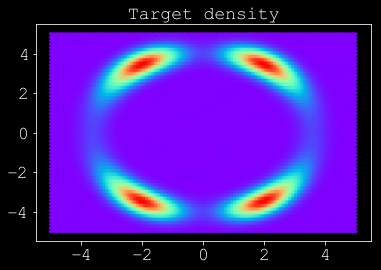

In [13]:
def density_ring(z):
    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return torch.exp(-u)

# Plot it
x = np.linspace(-5, 5, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])
plt.hexbin(z[:,0], z[:,1], C=density_ring(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
plt.title('Target density', fontsize=18);

Now to approximate such a complicated density, we will need to chain multiple planar flows and optimize their parameters to find a suitable approximation. We can do exactly that like in the following (you can see that we start by a simple normal density and perform 16 successive planar flows)

In [18]:
# Main class for normalizing flow
class NormalizingFlow(nn.Module):

    def __init__(self, dim, flow_length, density):
        super().__init__()
        biject = []
        for f in range(flow_length):
            biject.append(PlanarFlow(dim))
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density
        self.final_density = distrib.TransformedDistribution(density, self.transforms)
        self.log_det = []

    def forward(self, z):
        self.log_det = []
        # Applies series of flows
        for b in range(len(self.bijectors)):
            self.log_det.append(self.bijectors[b].log_abs_det_jacobian(z))
            z = self.bijectors[b](z)
        return z, self.log_det
    
# Create normalizing flow
flow = NormalizingFlow(dim=2, flow_length=16, density=distrib.MultivariateNormal(torch.zeros(2), torch.eye(2)))

Now the only missing ingredient is the loss function that is simply defined as follows

In [19]:
def loss(density, zk, log_jacobians):
        
    ######################
    # YOUR CODE GOES HERE
    ######################
    
    ######################
    # Solution
    sum_of_log_jacobians = sum(log_jacobians)
    loss = (-sum_of_log_jacobians - torch.log(density(zk) + 1e-9)).mean()
    ######################
    
    return loss

We can now perform optimization as usual by defining an optimizer, the parameters it will act on and eventually a learning rate scheduler

In [20]:
import torch.optim as optim
# Create optimizer algorithm
optimizer = optim.Adam(flow.parameters(), lr=2e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

And now we perform the loop by sampling a batch (here of 512) from the reference Normal distribution, and then evaluating our loss with respect to the density we want to approximate.

Loss (it. 0) : 18.481998
Loss (it. 1000) : 2.500382
Loss (it. 2000) : 0.940553
Loss (it. 3000) : 0.843522
Loss (it. 4000) : 0.797693
Loss (it. 5000) : 0.712306
Loss (it. 6000) : 0.765989
Loss (it. 7000) : 0.607698
Loss (it. 8000) : 0.700782
Loss (it. 9000) : 0.611475
Loss (it. 10000) : 0.604107


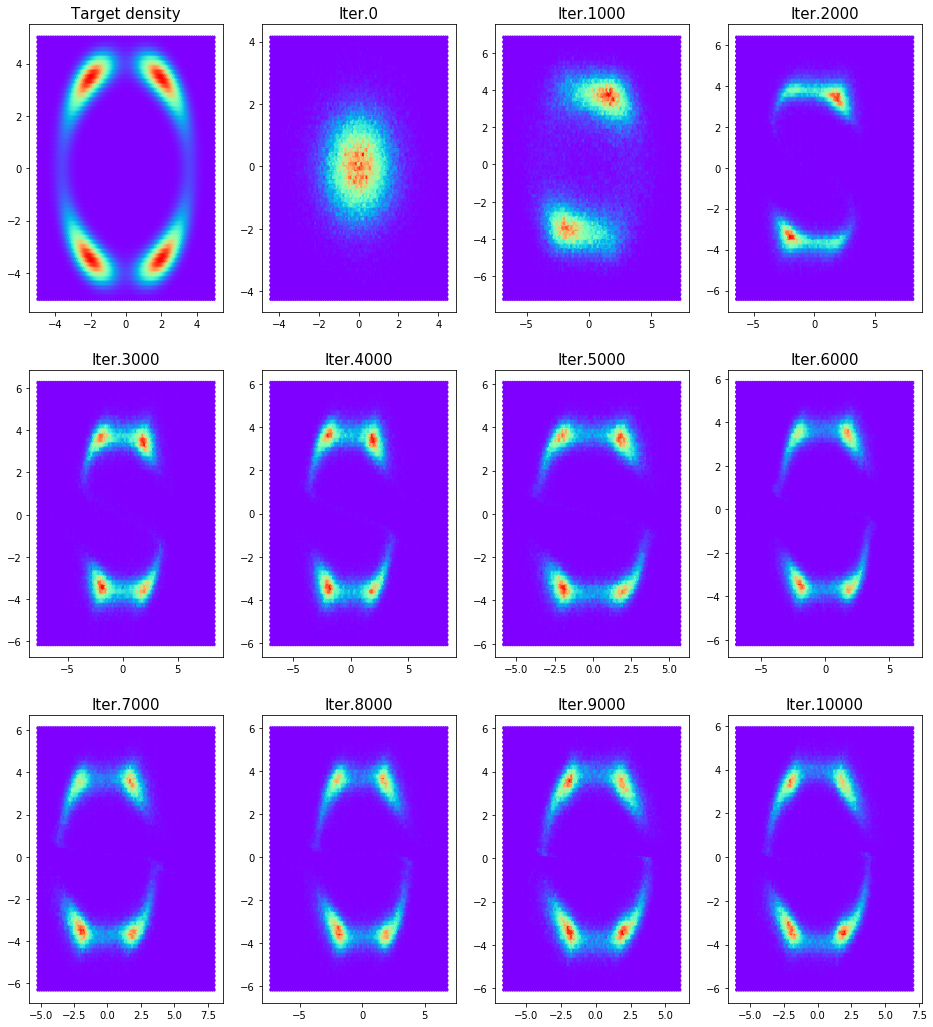

In [21]:
ref_distrib = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
id_figure=2
plt.figure(figsize=(16, 18))
plt.subplot(3,4,1)
plt.hexbin(z[:,0], z[:,1], C=density_ring(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
plt.title('Target density', fontsize=15);
# Main optimization loop
for it in range(10001):
    # Draw a sample batch from Normal
    samples = ref_distrib.sample((512, ))
    # Evaluate flow of transforms
    zk, log_jacobians = flow(samples)
    # Evaluate loss and backprop
    optimizer.zero_grad()
    loss_v = loss(density_ring, zk, log_jacobians)
    loss_v.backward()
    optimizer.step()
    scheduler.step()
    if (it % 1000 == 0):
        print('Loss (it. %i) : %f'%(it, loss_v.item()))
        # Draw random samples
        samples = ref_distrib.sample((int(1e5), ))
        # Evaluate flow and plot
        zk, _ = flow(samples)
        zk = zk.detach().numpy()
        plt.subplot(3,4,id_figure)
        plt.hexbin(zk[:,0], zk[:,1], cmap='rainbow')
        plt.title('Iter.%i'%(it), fontsize=15);
        id_figure += 1

That concludes this tutorial ! In the next one we will see how to implement more complicated flows and how this can fit in a global inference framework

### References

<a id="reference1"></a>
[1] Rezende, Danilo Jimenez, and Shakir Mohamed. "Variational inference with normalizing flows." _arXiv preprint arXiv:1505.05770_ (2015). [link](http://arxiv.org/pdf/1505.05770)

[2] Kingma, Diederik P., Tim Salimans, and Max Welling. "Improving Variational Inference with Inverse Autoregressive Flow." _arXiv preprint arXiv:1606.04934_ (2016). [link](https://arxiv.org/abs/1606.04934)

[3] Germain, Mathieu, et al. "Made: masked autoencoder for distribution estimation." International Conference on Machine Learning. 2015.

### Inspirations and resources

https://blog.evjang.com/2018/01/nf1.html  
https://github.com/ex4sperans/variational-inference-with-normalizing-flows  
https://akosiorek.github.io/ml/2018/04/03/norm_flows.html  
https://github.com/abdulfatir/normalizing-flows  

